In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel

Convert chrX with males to zarr for analysis later

In [2]:
#chrX_vcf = allel.read_vcf("/faststorage/project/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chrX_with_males/chrX_diploid_all_nomiss.vcf.gz")

In [3]:
input_vcf = "/faststorage/project/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chrX_with_males/chrX_diploid_all_nomiss.vcf.gz"
zarr_chrX = "/home/eriks/baboondiversity/data/callset.zarr/all_chrX"
#allel.vcf_to_zarr(input_vcf, zarr_chrX, fields='*')

<Axes: xlabel='generations', ylabel='autosomal admixture'>

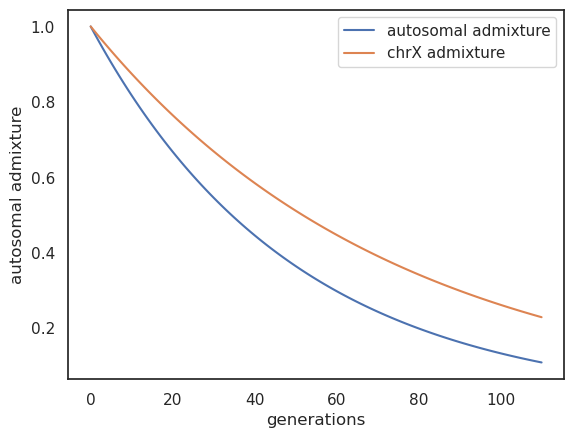

In [4]:
auto_perc, x_perc = 1, 1
gen_admix, admix_prop, male_bias = 111, 0.02, 1
auto_perc_his, x_perc_his, gen_his = [], [], []

for i in range(gen_admix):
    auto_perc_his.append(auto_perc), x_perc_his.append(x_perc), gen_his.append(i)
    #print(auto_perc*100, x_perc*100, x_perc/auto_perc)
    auto_perc = auto_perc*(1-admix_prop)
    x_perc = x_perc*(1-admix_prop*(male_bias*2/3+(1-male_bias)*4/3))
gen_df = pd.DataFrame({"generations": gen_his, "autosomal admixture": auto_perc_his, "chrX admixture": x_perc_his})
sns.lineplot(data=gen_df, x="generations", y="autosomal admixture", label="autosomal admixture")
sns.lineplot(data=gen_df, x="generations", y="chrX admixture", label="chrX admixture")

<Axes: xlabel='generations', ylabel='autosomal admixture'>

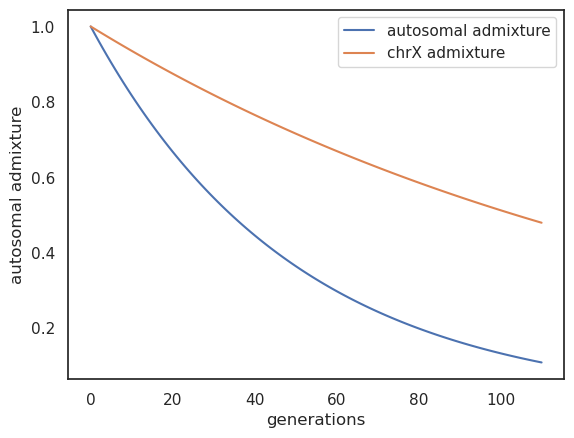

In [5]:
auto_perc, x_perc = 1, 1
gen_admix, admix_prop, male_bias = 111, 0.02, 1
auto_perc_his, x_perc_his, gen_his = [], [], []

for i in range(gen_admix):
    auto_perc_his.append(auto_perc), x_perc_his.append(x_perc), gen_his.append(i)
    #print(auto_perc*100, x_perc*100, x_perc/auto_perc)
    auto_perc = auto_perc*(1-admix_prop)
    x_perc = x_perc*(1-admix_prop*(male_bias*2/3+(1-male_bias)*4/3)*0.5)
gen_df = pd.DataFrame({"generations": gen_his, "autosomal admixture": auto_perc_his, "chrX admixture": x_perc_his})
sns.lineplot(data=gen_df, x="generations", y="autosomal admixture", label="autosomal admixture")
sns.lineplot(data=gen_df, x="generations", y="chrX admixture", label="chrX admixture")

<Axes: xlabel='generations', ylabel='autosomal admixture'>

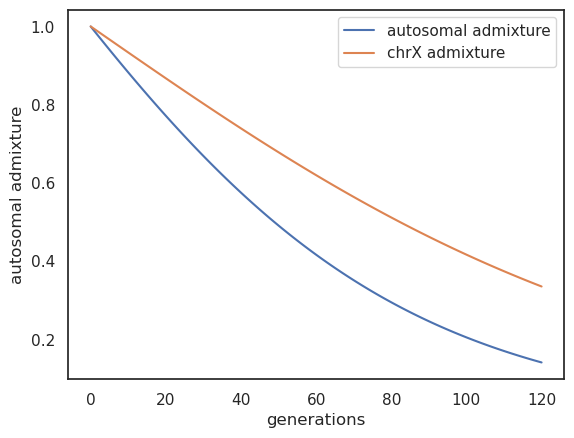

In [6]:
auto_perc, x_perc = 1, 1
gen_admix, admix_prop, male_bias = 121, 0.02, 1
auto_perc_his, x_perc_his, gen_his = [], [], []

for i in range(gen_admix):
    auto_perc_his.append(auto_perc), x_perc_his.append(x_perc), gen_his.append(i)
    #print(auto_perc*100, x_perc*100, x_perc/auto_perc)
    auto_perc = auto_perc*(1-admix_prop*(1-auto_perc*0.4))
    x_perc = x_perc*(1-admix_prop*(male_bias*2/3+(1-male_bias)*4/3)*(1-x_perc*0.5))
gen_df = pd.DataFrame({"generations": gen_his, "autosomal admixture": auto_perc_his, "chrX admixture": x_perc_his})
sns.lineplot(data=gen_df, x="generations", y="autosomal admixture", label="autosomal admixture")
sns.lineplot(data=gen_df, x="generations", y="chrX admixture", label="chrX admixture")

In [7]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Cynocephalus, Central Tanzania': 0,
 'Papio, Senegal': 0,
 'Anubis, Tanzania': 0}

def create_paint_df_ind_compressed(df, ind, mapping, ns_map):
    d = {}
    max_pos = int(df.epos.iloc[-1])
    df = df.loc[df[ind].shift() != df[ind]].reset_index()
    df["epos"] = pd.concat([df.spos.iloc[1:], pd.Series(max_pos)], ignore_index=True)
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [8]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [9]:
@window(size=100000)
def north_sum(df):
    return (df.end-df.start).sum()

def add_dummy(c_df):
    inds = c_df.individual.unique()
    dummy_df = pd.DataFrame({"individual": np.repeat(inds, 2)})
    dummy_df["haplotype"] = pd.Series(["0", "1"]*len(inds))
    dummy_df["end"], dummy_df["start"] = c_df.end.max(), c_df.end.max()
    dummy_df["chrom"] = c_df.chrom.unique()[0]
    return dummy_df

rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []

for c in length_df.chrom.unique():
    output_file = rfmix_path + "{}.windows.txt".format(c)
    print(output_file)
    if os.path.exists(output_file) == False:
        c_df = length_df.loc[(length_df.chrom == c) & (length_df["n/s"] == 1)]
        c_df = c_df.rename(columns={"pos": "start", "end_pos": "end"})
        dummy_added = pd.concat([c_df, add_dummy(c_df)]).reset_index()
        df = dummy_added.groupby(['chrom', 'individual', 'haplotype'])[["end", "start"]].apply(north_sum).reset_index(drop=True, level=-1).reset_index()
        df.to_csv(output_file, index=False, sep="\t")

/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr1.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr2.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr3.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr4.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr5.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr6.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr7.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/chr8.windows.txt
/home/eriks/baboondiversity/people/eriks/second_analysis_baboons

First, diversity and Fst estimates for the ethiopian olives.

In [10]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])
pos = callset["variants/POS"][:]

In [11]:
meta_data_samples.C_origin.unique()

array(['Cynocephalus, Central Tanzania', 'Anubis, Kenya',
       'Kindae, Zambia', 'Gelada, Captive', 'Hamadryas, Ethiopia',
       'Anubis, Tanzania', 'Cynocephalus, Western Tanzania',
       'Papio, Senegal', 'Ursinus, Zambia', 'Anubis, Ethiopia'],
      dtype=object)

In [12]:
gog_index = meta_data_samples.loc[(meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia") &
                                    (meta_data_samples.Sex == "F")].callset_index
gog_gt = gt.take(gog_index, axis=1)
filoha_index = meta_data_samples.loc[(meta_data_samples.Origin == "Filoha, Ethiopia") &
                                    (meta_data_samples.Sex == "F")].callset_index
filoha_gt = gt.take(filoha_index, axis=1)
tanza_olive_index = meta_data_samples.loc[(meta_data_samples.C_origin == "Anubis, Tanzania") &
                                    (meta_data_samples.Sex == "F")].callset_index
tanza_olive_gt = gt.take(tanza_olive_index, axis=1)

In [13]:
window_size = int(250000)
pi, windows, n_bases, counts = allel.windowed_diversity(pos, ac=gog_gt.count_alleles(), size=window_size)
start_points = list(range(0, len(pi)*window_size, window_size))
gog_df = pd.DataFrame({"pi": pi, "chrom": "chrX", "pop_id": "Mikumi", "start": start_points})

In [14]:
pi, windows, n_bases, counts = allel.windowed_diversity(pos, ac=filoha_gt.count_alleles(), size=window_size)
start_points = list(range(0, len(pi)*window_size, window_size))
filoha_df = pd.DataFrame({"pi": pi, "chrom": "chrX", "pop_id": "Mikumi", "start": start_points})

In [15]:
pi, windows, n_bases, counts = allel.windowed_diversity(pos, ac=tanza_olive_gt.count_alleles(), size=window_size)
start_points = list(range(0, len(pi)*window_size, window_size))
tanza_df = pd.DataFrame({"pi": pi, "chrom": "chrX", "pop_id": "Mikumi", "start": start_points})

In [16]:
gog_df.pi.mean(), filoha_df.pi.mean(), tanza_df.pi.mean()

(0.0006939183535128639, 0.0008096797902603845, 0.0009473688977180841)

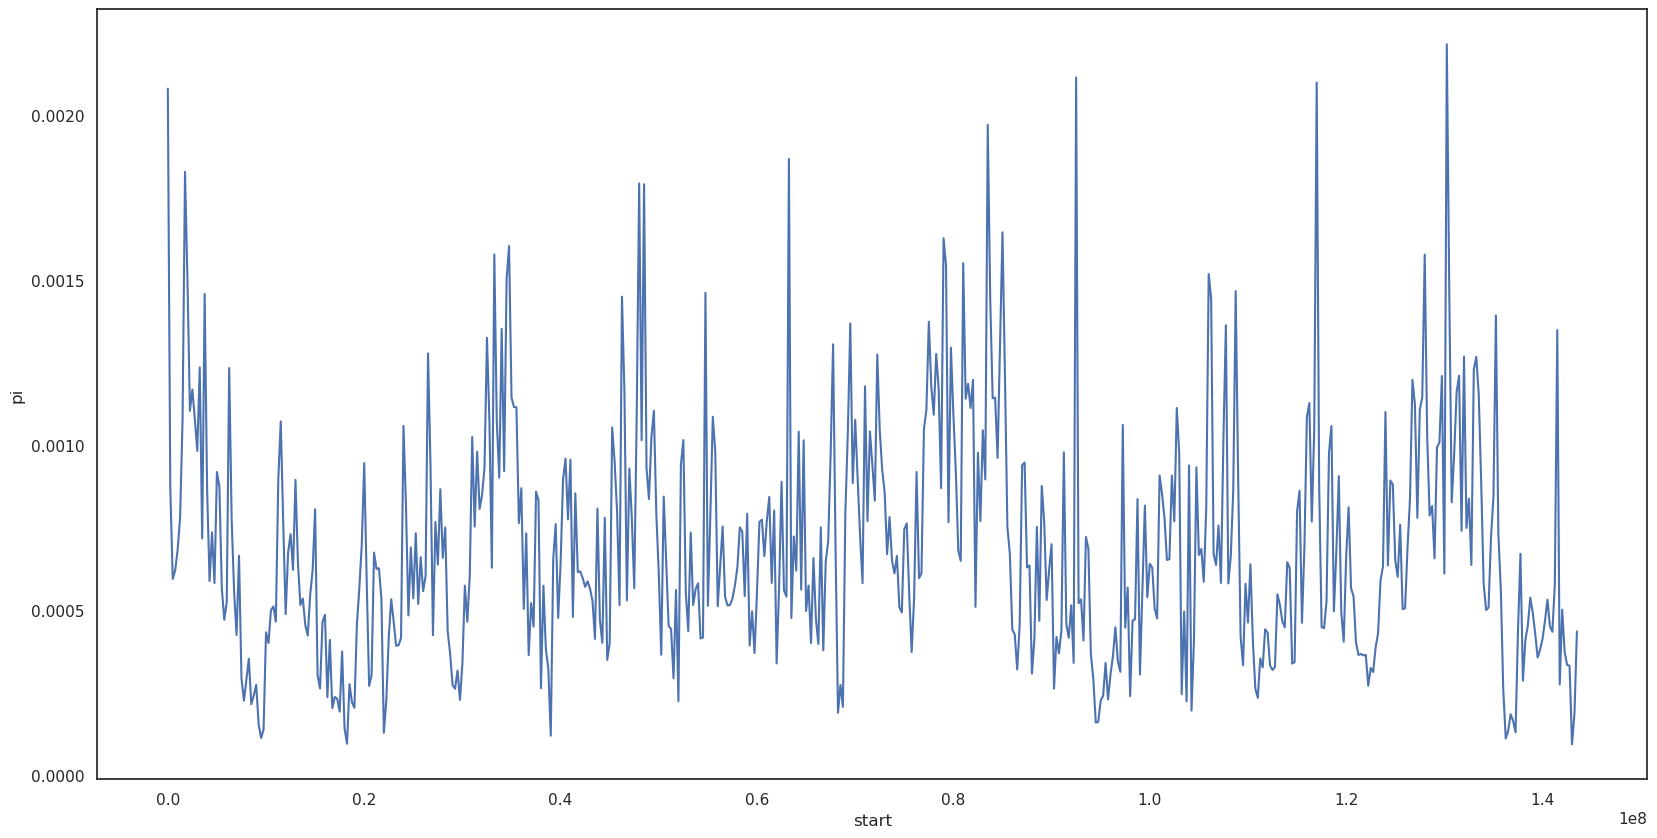

In [21]:
plt.figure(figsize=(20,10))
g = sns.lineplot(data=gog_df, x="start", y="pi")

In [27]:
gog_df["norm_pi"] = gog_df.pi/(gog_df.pi.mean())/(tanza_df.pi/tanza_df.pi.mean())

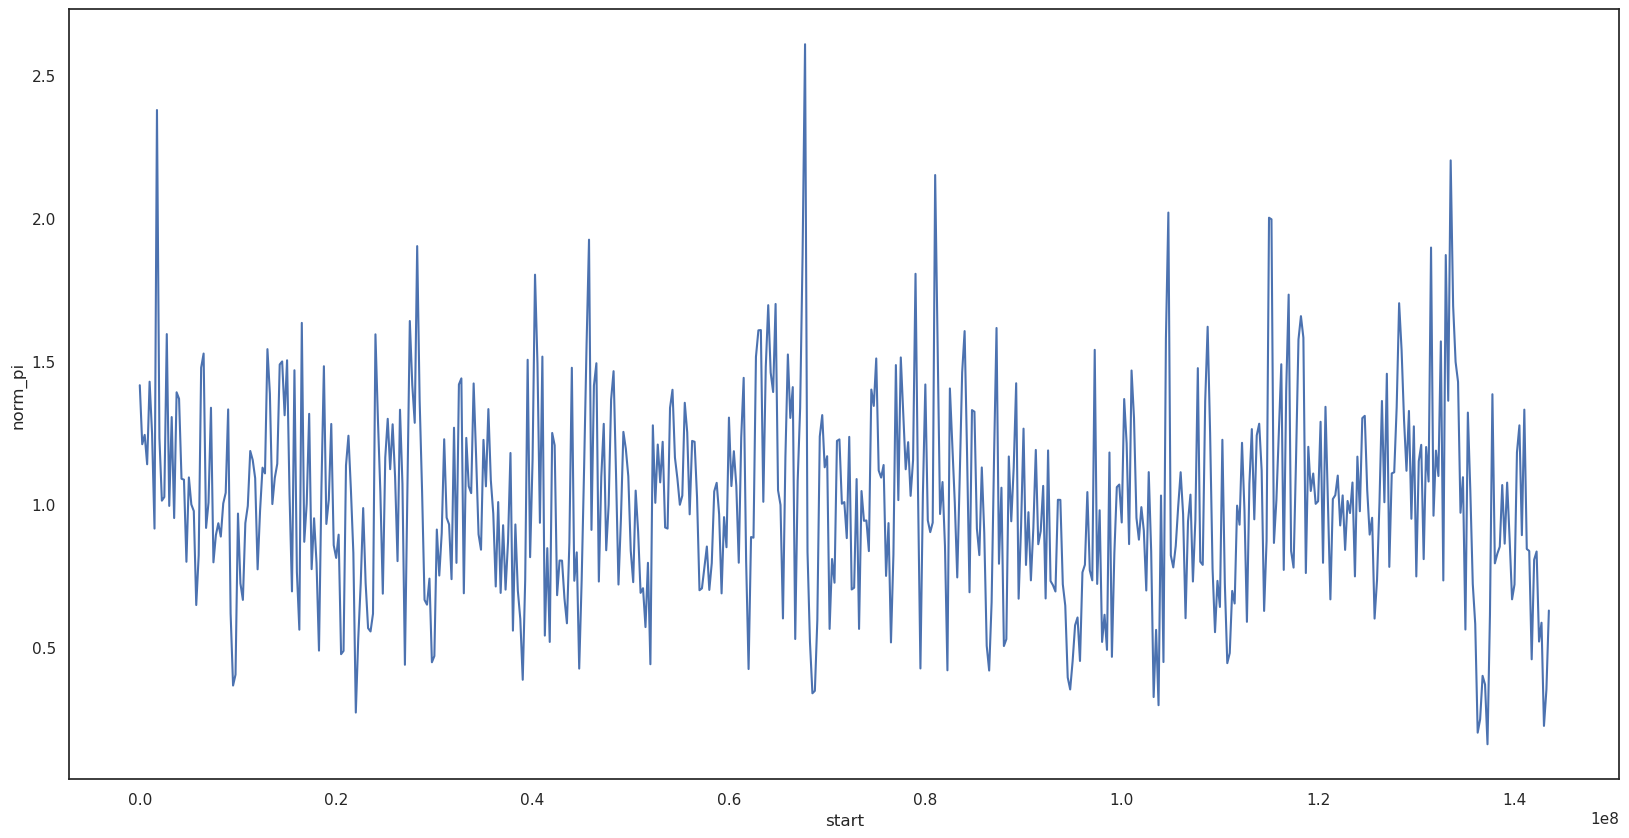

In [28]:
plt.figure(figsize=(20,10))
g = sns.lineplot(data=gog_df, x="start", y="norm_pi")

In [19]:
gog_df.loc[gog_df.pi < 0.0002].start

37       9250000
38       9500000
39       9750000
70      17500000
72      18000000
73      18250000
88      22000000
156     39000000
273     68250000
378     94500000
379     94750000
417    104250000
545    136250000
546    136500000
547    136750000
548    137000000
549    137250000
572    143000000
573    143250000
Name: start, dtype: int64

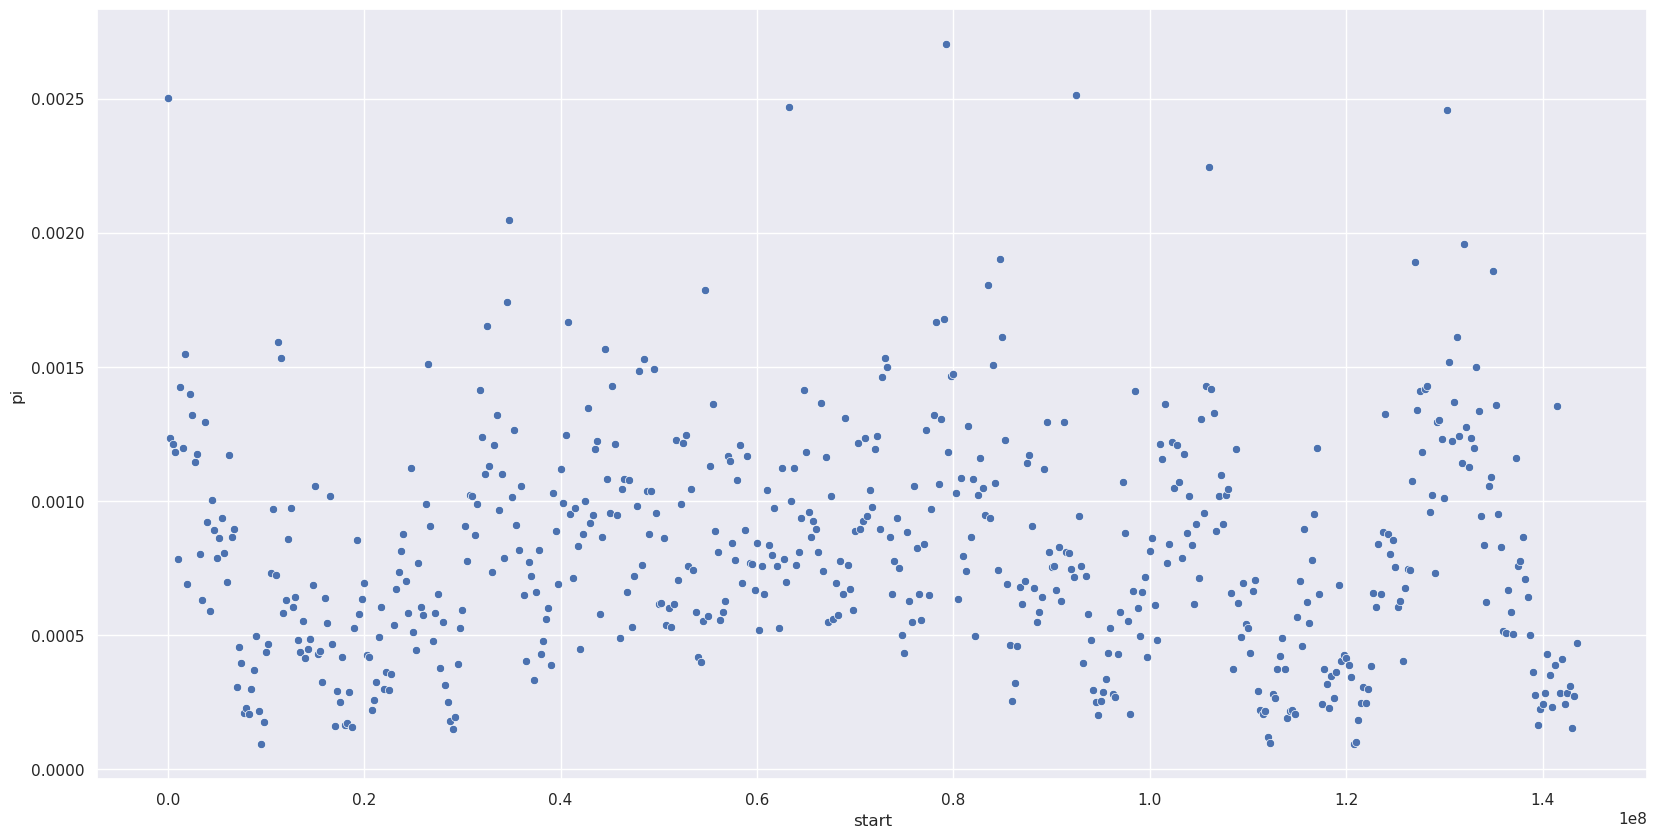

In [20]:
g = sns.scatterplot(data=filoha_df, x="start", y="pi")

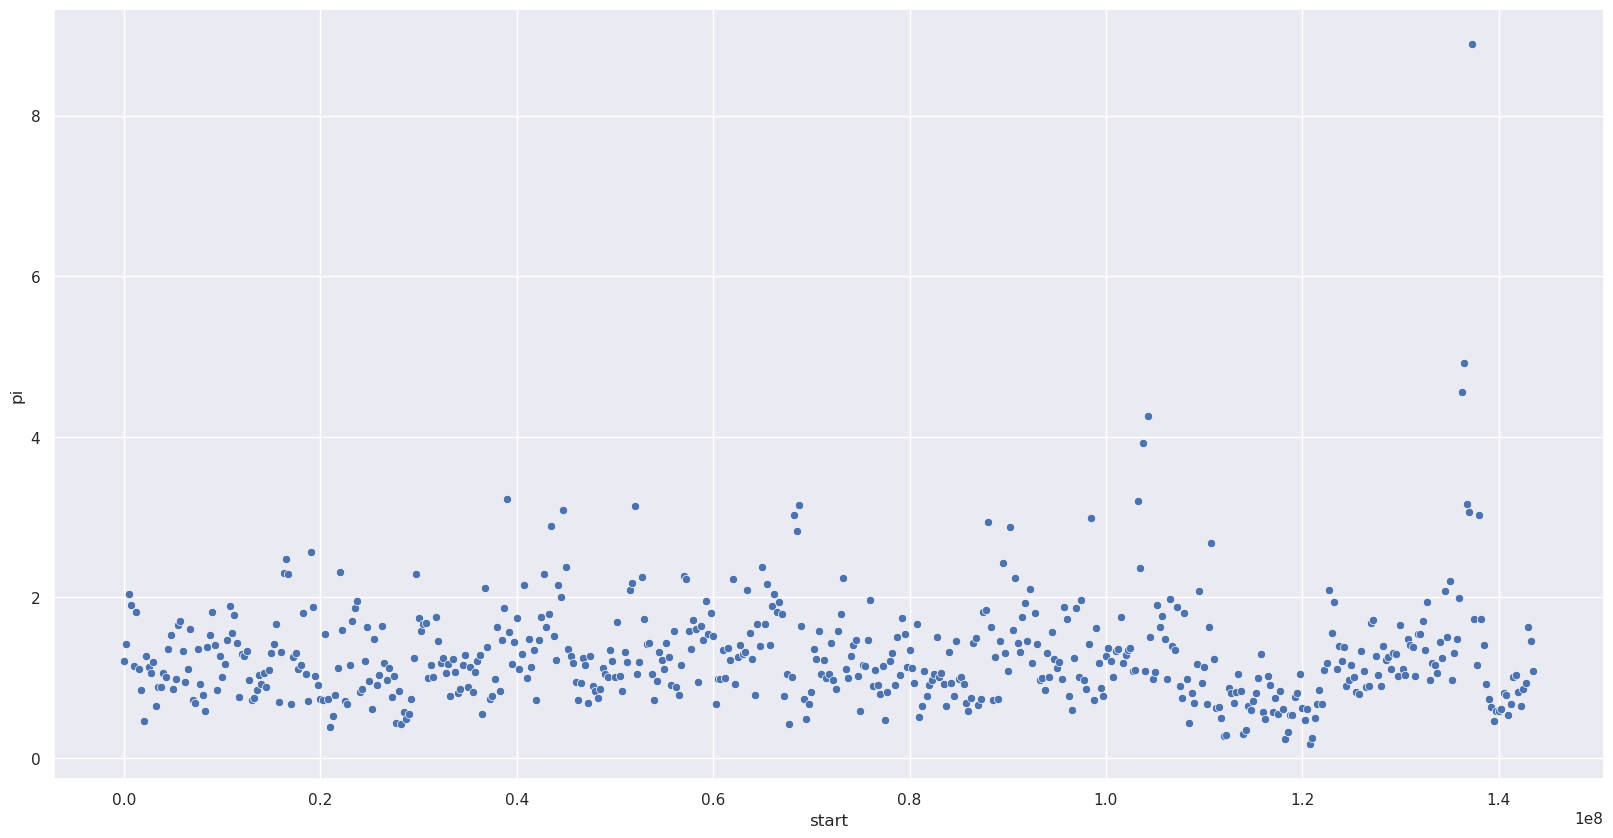

In [21]:
g = sns.scatterplot(x=filoha_df.start, y=filoha_df.pi/gog_df.pi)

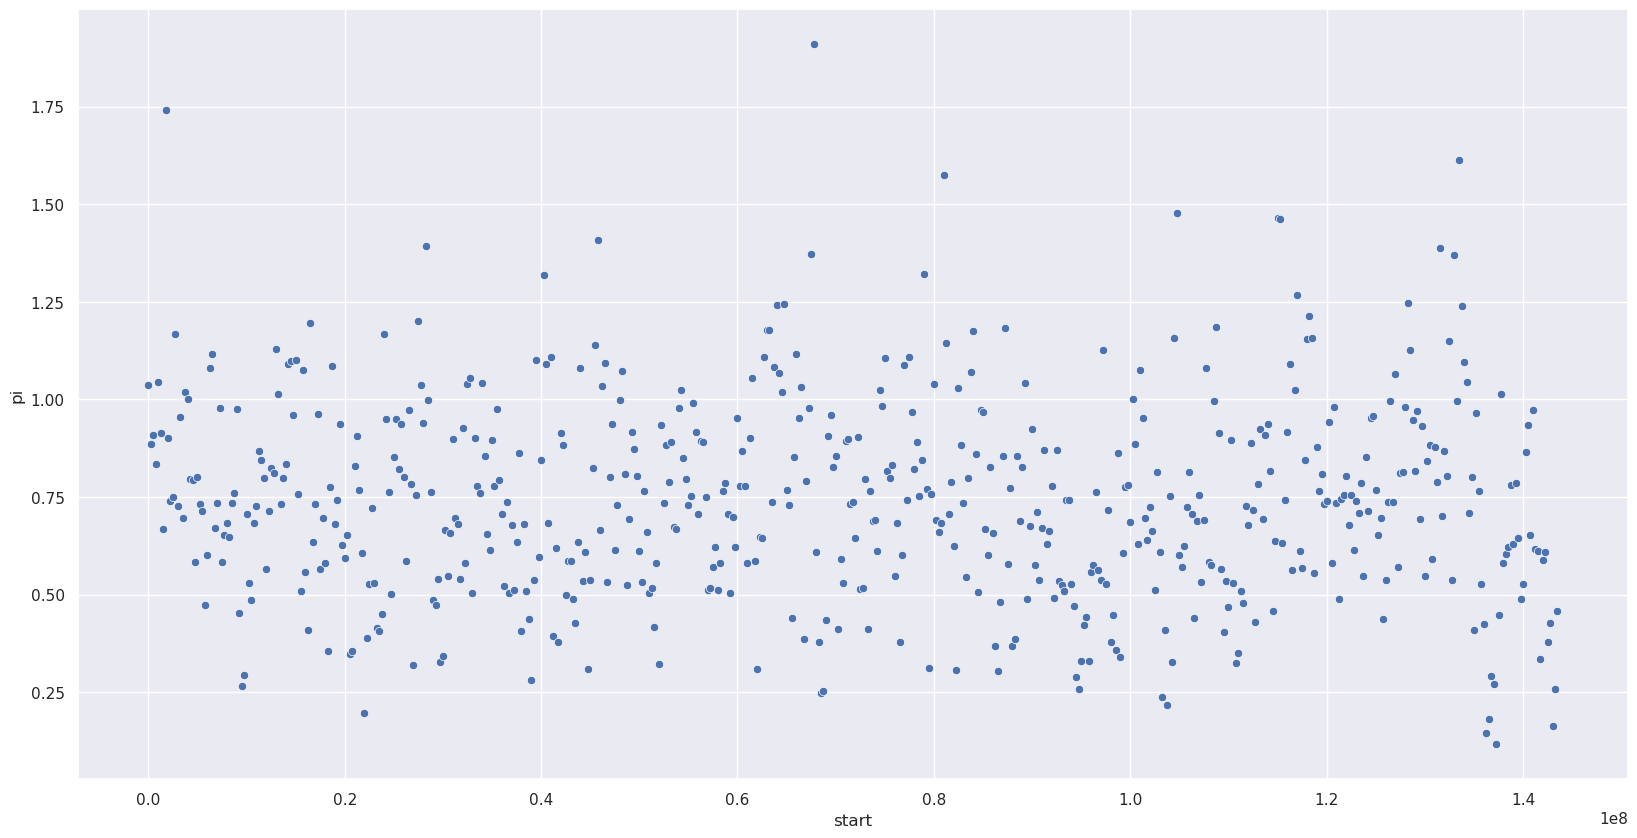

In [22]:
g = sns.scatterplot(x=filoha_df.start, y=gog_df.pi/tanza_df.pi)

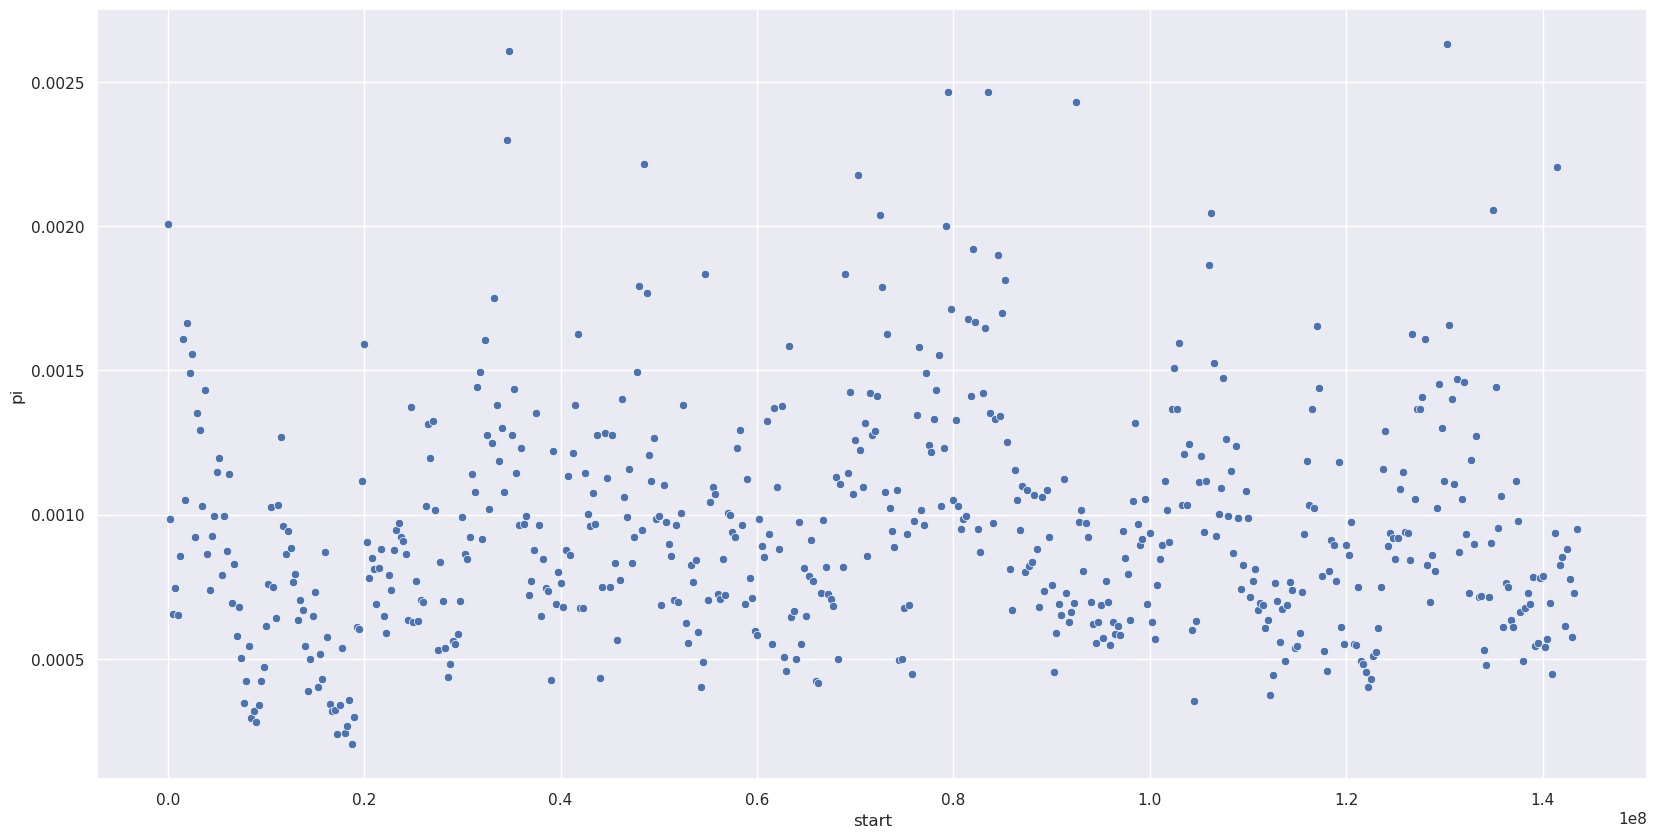

In [23]:
g = sns.scatterplot(data=tanza_df, x="start", y="pi")

In [29]:
def fst(ac1, ac2):
    num, den = allel.hudson_fst(ac1, ac2, fill=0)
    return np.sum(num) / np.sum(den)

In [30]:
out, windows, counts = allel.windowed_statistic(pos, (gog_gt.count_alleles(), filoha_gt.count_alleles()), fst, size=window_size)
fst_df_gf = pd.DataFrame({"fst": out, "chrom": "chrX", "pop_id": "Gog_Fil_Fst", "start": start_points})

out, windows, counts = allel.windowed_statistic(pos, (gog_gt.count_alleles(), tanza_olive_gt.count_alleles()), fst, size=window_size)
fst_df_gt = pd.DataFrame({"fst": out, "chrom": "chrX", "pop_id": "Gog_Tanz_Fst", "start": start_points})

out, windows, counts = allel.windowed_statistic(pos, (filoha_gt.count_alleles(), tanza_olive_gt.count_alleles()), fst, size=window_size)
fst_df_tf = pd.DataFrame({"fst": out, "chrom": "chrX", "pop_id": "Fil_Tanz_Fst", "start": start_points})

<Axes: xlabel='start', ylabel='fst'>

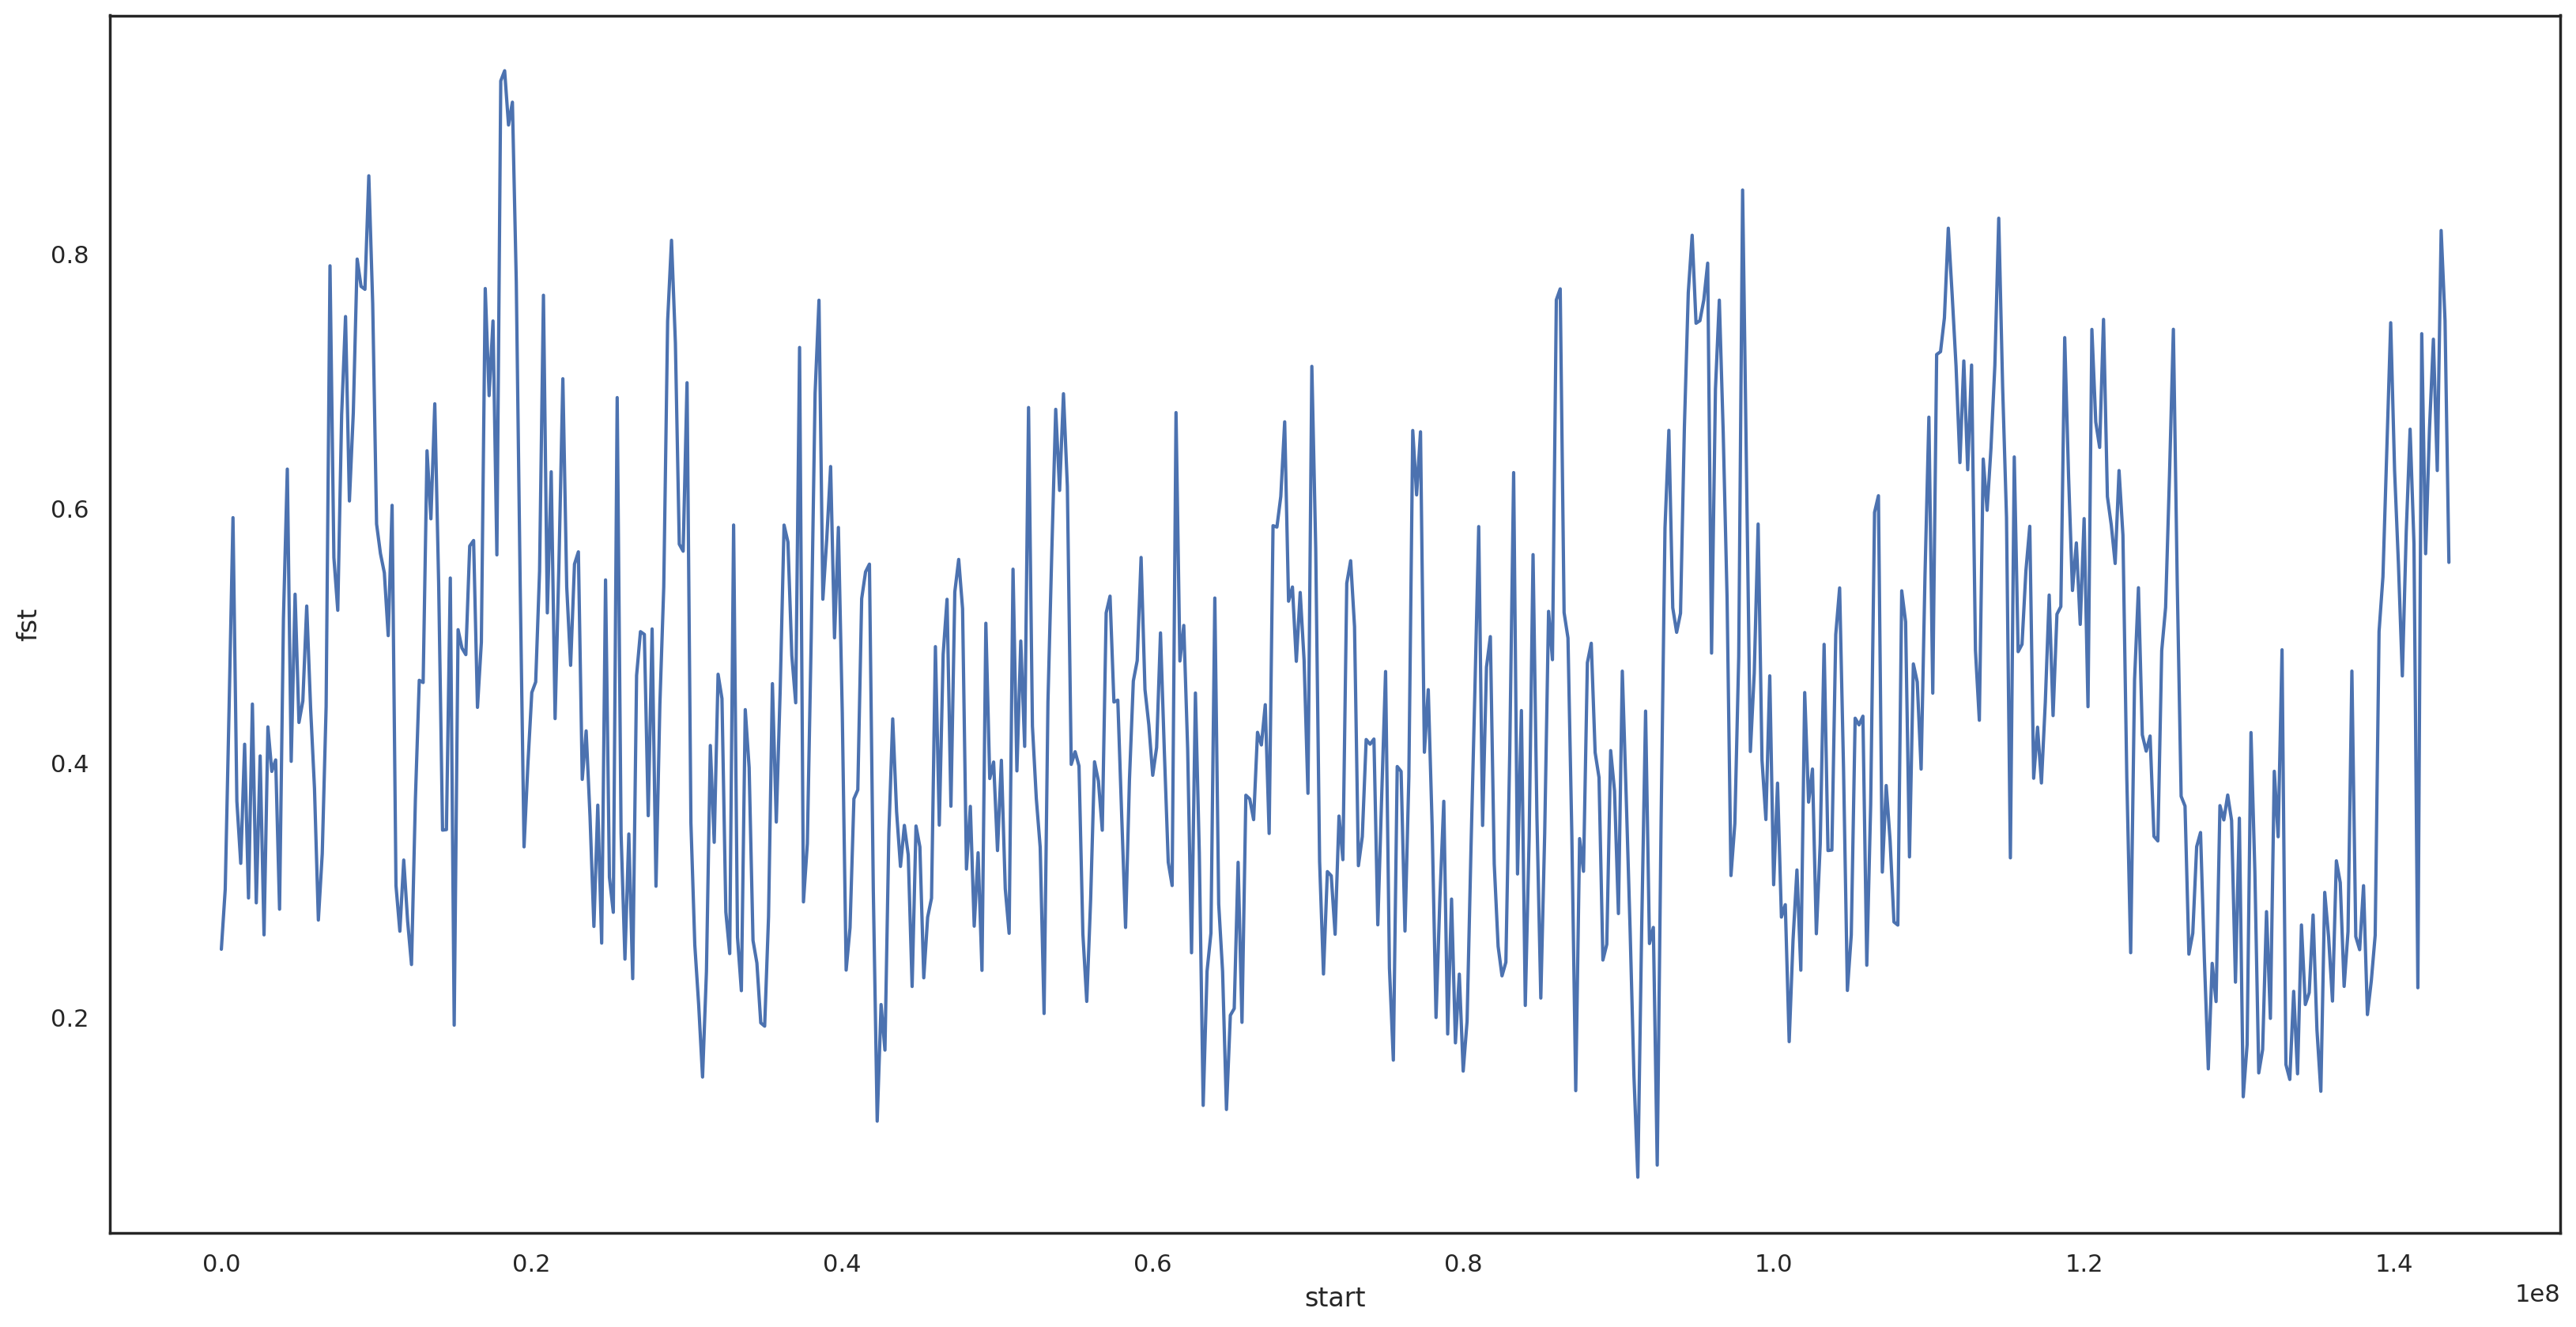

In [66]:
plt.figure(figsize=(20,10))

sns.lineplot(data=fst_df_gf, x="start", y="fst")

<Axes: xlabel='start', ylabel='fst'>

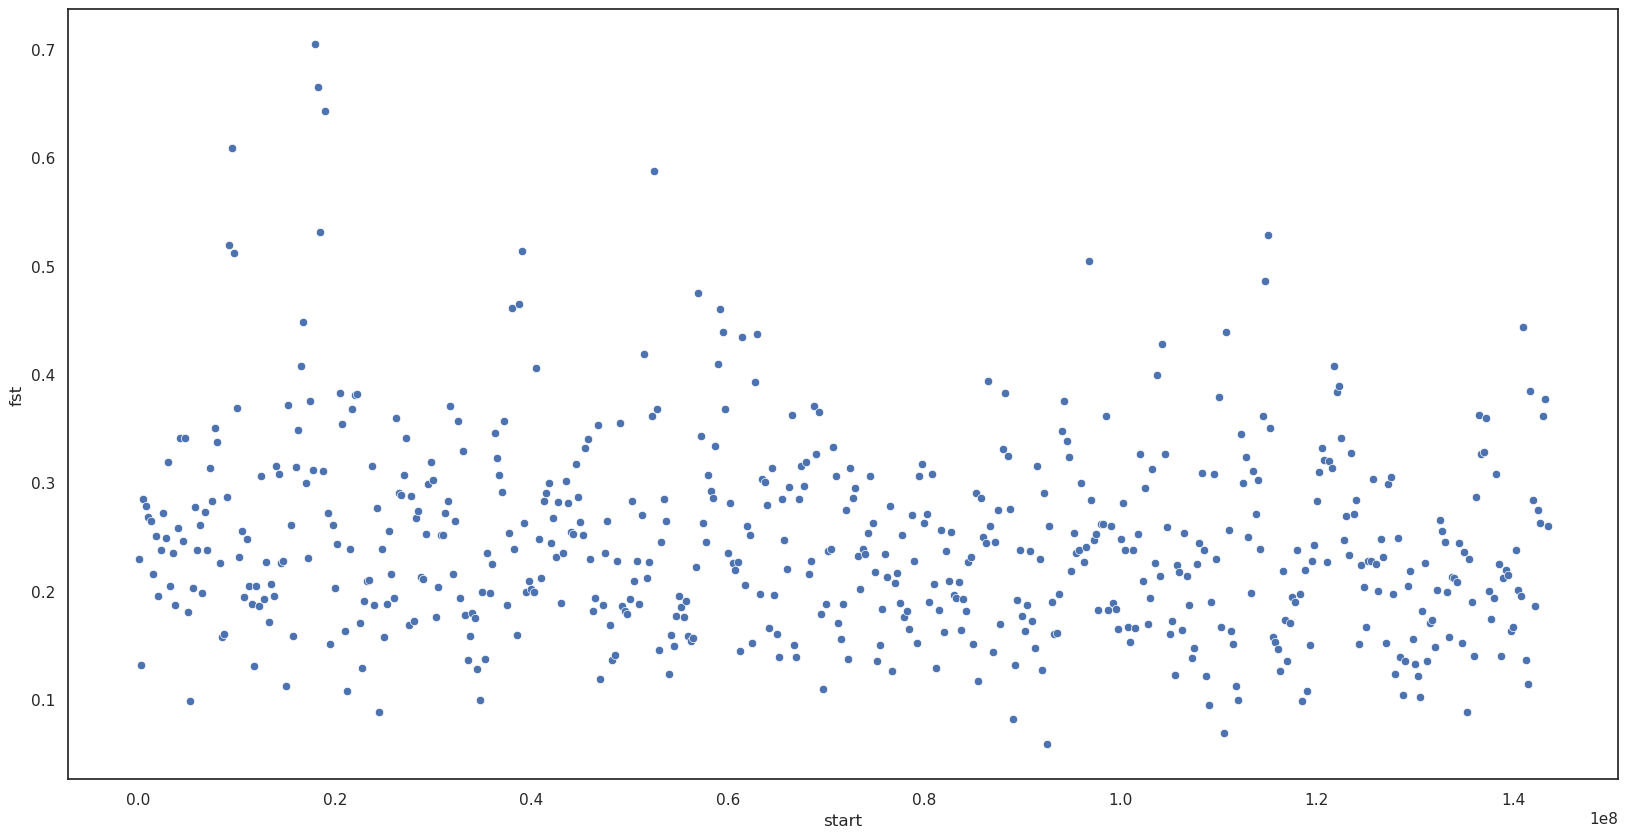

In [32]:
plt.figure(figsize=(20,10))

sns.scatterplot(data=fst_df_gt, x="start", y="fst")

<Axes: xlabel='start', ylabel='Relative Fst'>

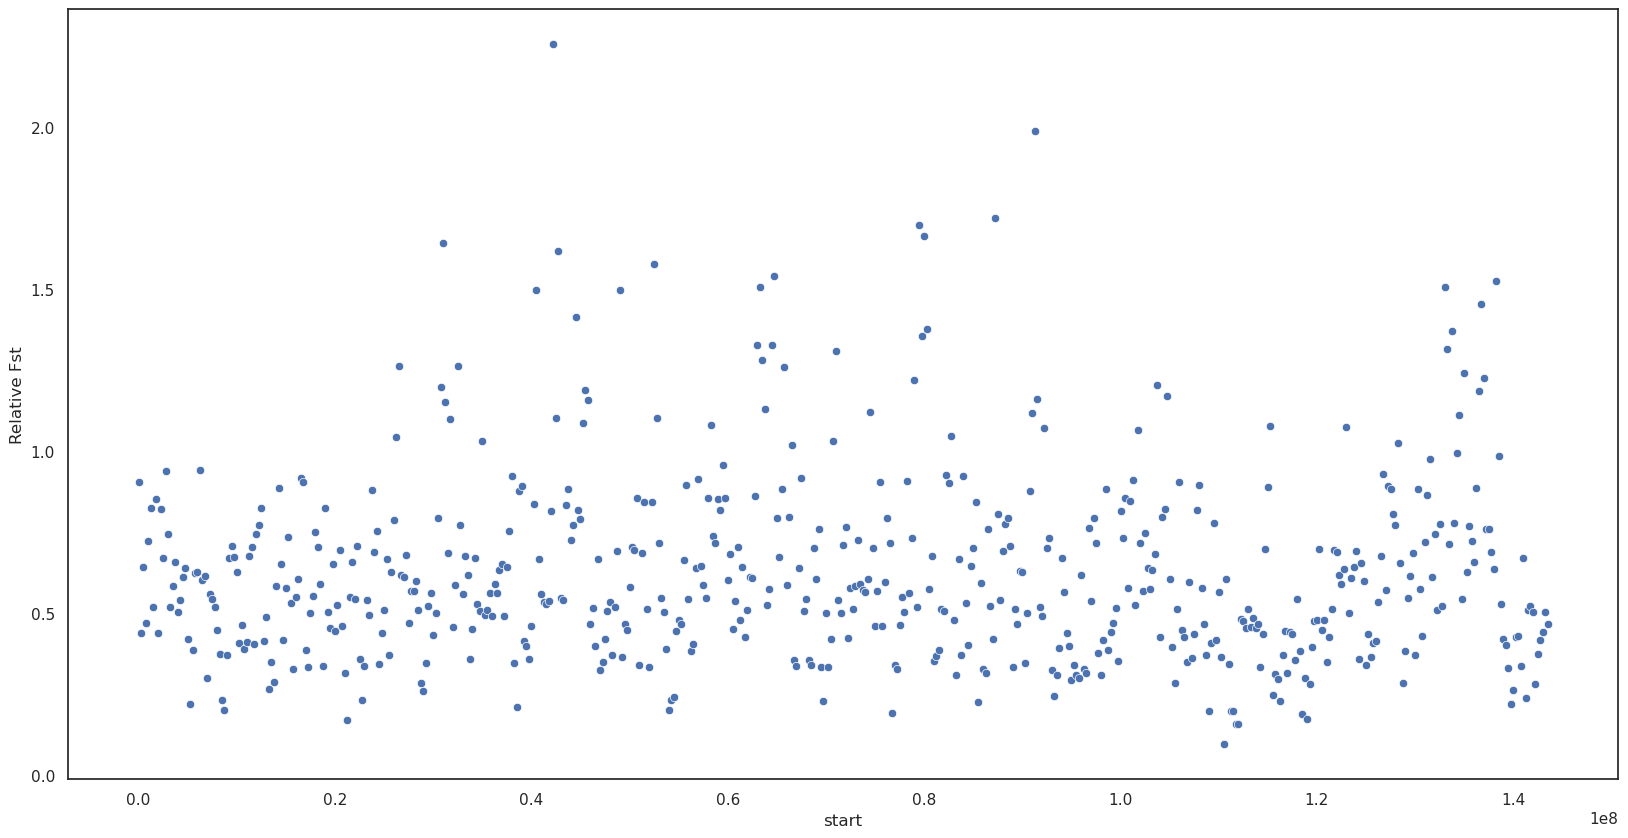

In [36]:
fst_df_gt["Relative Fst"] = fst_df_gt.fst/fst_df_gf.fst
plt.figure(figsize=(20,10))

sns.scatterplot(data=fst_df_gt, x="start", y="Relative Fst")

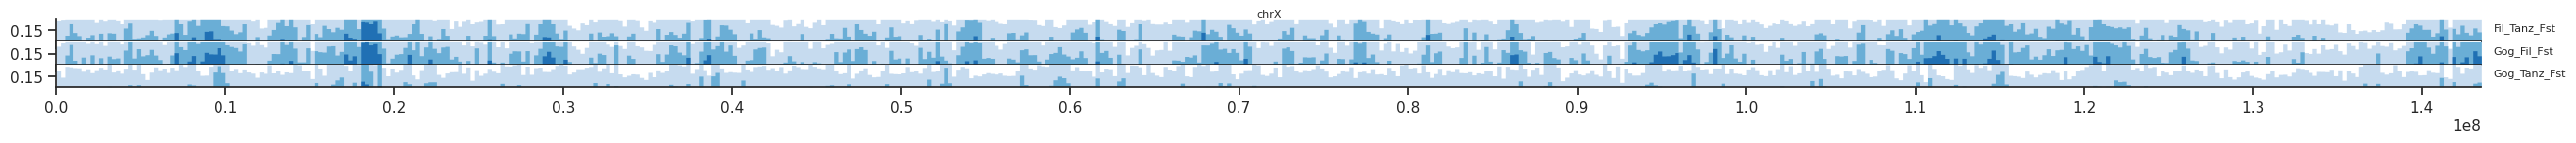

In [27]:
concat_df = pd.concat([fst_df_gf, fst_df_gt, fst_df_tf])
fig = horizonplot(concat_df, 'fst', width=2, col='chrom', row='pop_id', size=0.3, aspect=100)


Checking a single inds Fst relationships.

In [28]:
gog_ind_index = meta_data_samples.loc[(meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia") &
                                    (meta_data_samples.Sex == "F") &
                                     (meta_data_samples.PGDP_ID == "PD_0721")].callset_index
gog_ind_gt = gt.take(gog_ind_index, axis=1)

out, windows, counts = allel.windowed_statistic(pos, (gog_ind_gt.count_alleles(), filoha_gt.count_alleles()), fst, size=window_size)
fst_df_gf = pd.DataFrame({"fst": out, "chrom": "chrX", "pop_id": "Gog_Fil_Fst", "start": start_points})

out, windows, counts = allel.windowed_statistic(pos, (gog_ind_gt.count_alleles(), tanza_olive_gt.count_alleles()), fst, size=window_size)
fst_df_gt = pd.DataFrame({"fst": out, "chrom": "chrX", "pop_id": "Gog_Tanz_Fst", "start": start_points})

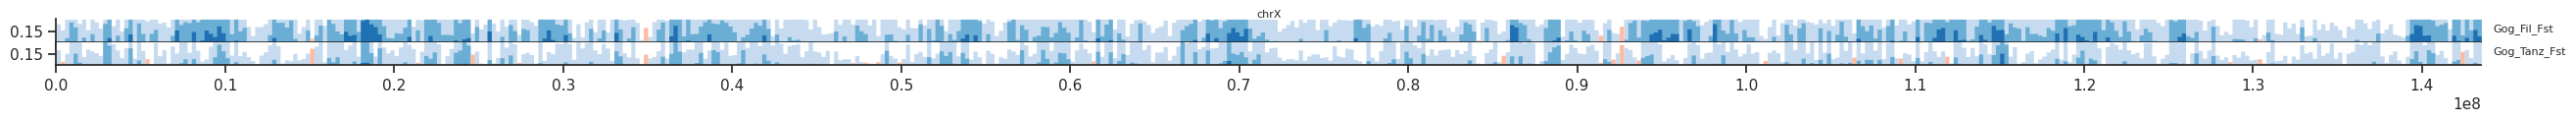

In [29]:
concat_df = pd.concat([fst_df_gf, fst_df_gt])
fig = horizonplot(concat_df, 'fst', width=2, col='chrom', row='pop_id', size=0.3, aspect=100)


In [37]:
df_l = []
for c in length_df.chrom.unique():
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)

In [38]:
mean_df = window_df_eth.groupby(by=["individual", "chrom", "start"])[["north_sum"]].mean().reset_index()
mean_df["north"] = (mean_df.north_sum*2)-100000
ethiopia = meta_data_samples.loc[meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia"].PGDP_ID
eth_olive_mean_df = mean_df.loc[(mean_df.individual.isin(ethiopia))]

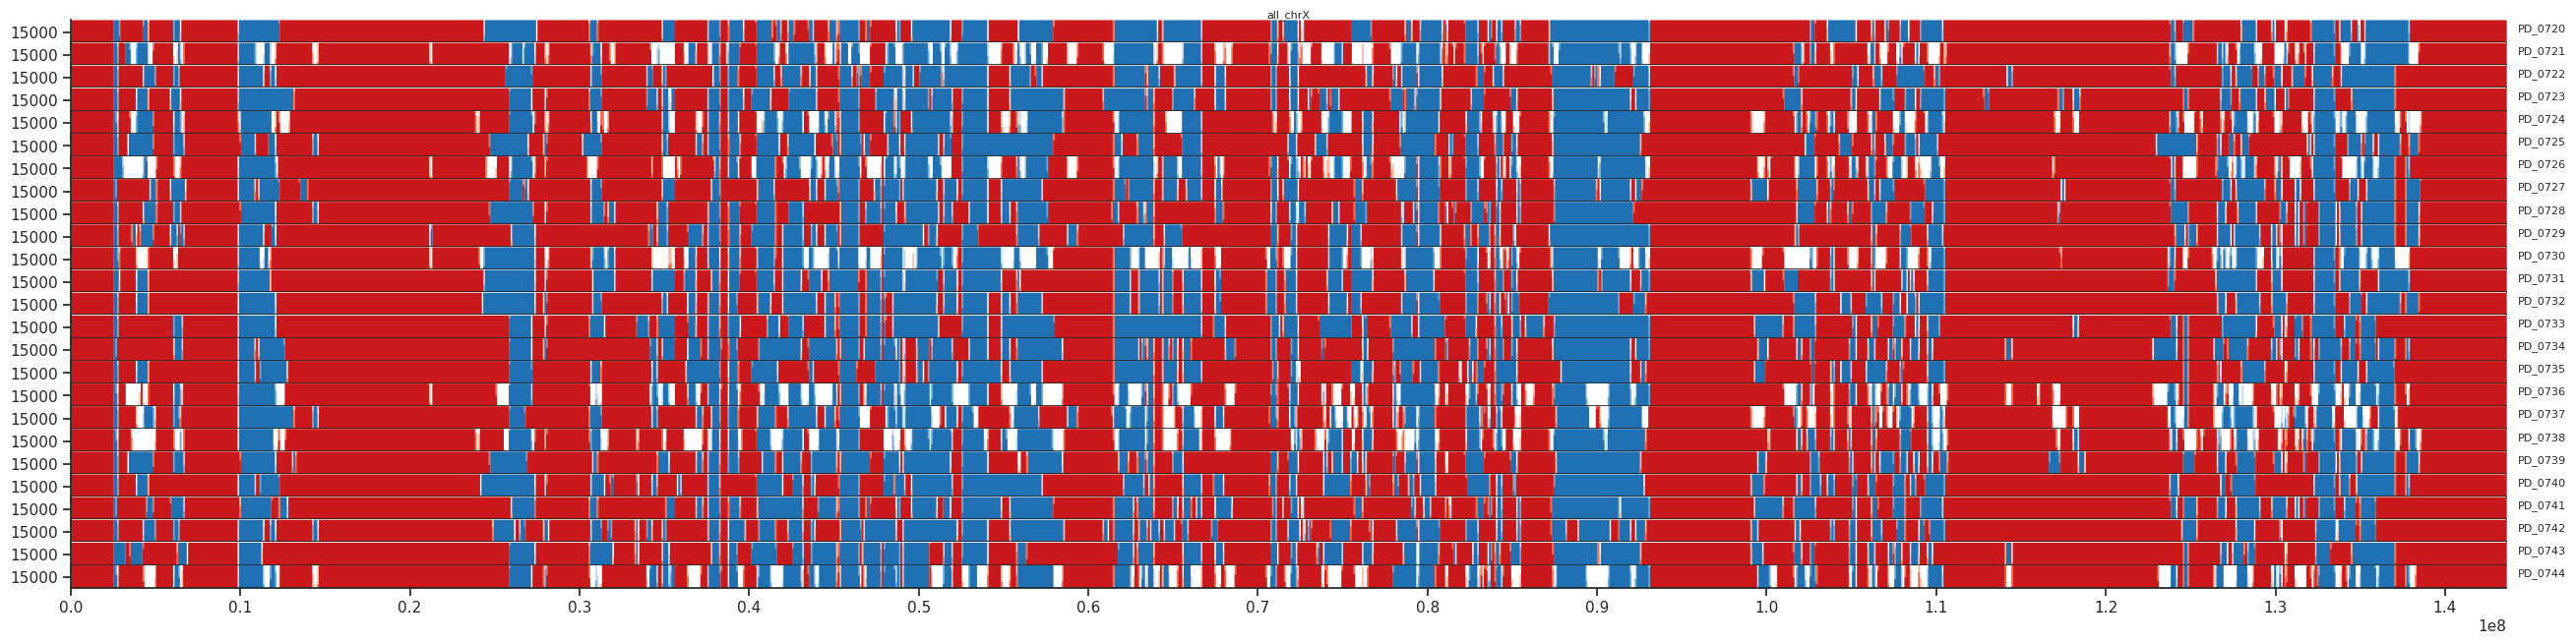

In [39]:
chr_check = eth_olive_mean_df.loc[(eth_olive_mean_df.chrom == "all_chrX")]
fig = horizonplot(chr_check, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

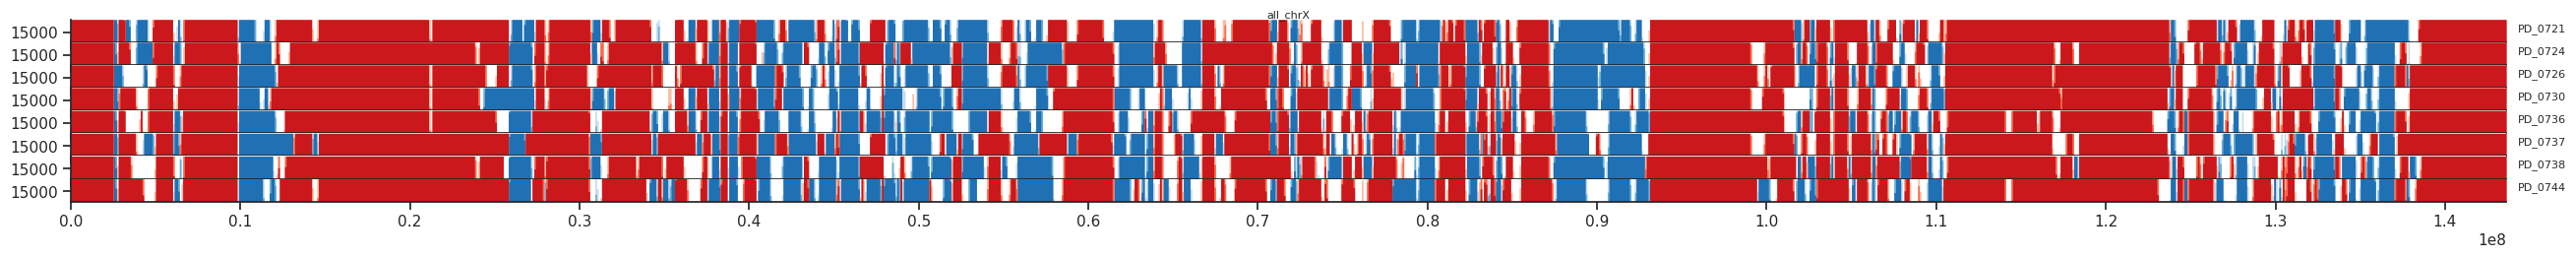

In [40]:
f_ethiopia = meta_data_samples.loc[(meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia") &
                                  (meta_data_samples.Sex == "F")].PGDP_ID
f_eth_olive_mean_df = mean_df.loc[(mean_df.individual.isin(f_ethiopia))]
chr_check = f_eth_olive_mean_df.loc[(f_eth_olive_mean_df.chrom == "all_chrX")]
fig = horizonplot(chr_check, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [41]:
# Adjusting male north
eth_olive_mean_df = mean_df.loc[(mean_df.individual.isin(ethiopia)) & (mean_df.chrom == "all_chrX")]
eth_olive_mean_df["sex"] = eth_olive_mean_df.individual.map(dict(zip(meta_data_samples.PGDP_ID,
                                                                     meta_data_samples.Sex)))
eth_olive_mean_df.loc[eth_olive_mean_df.sex == "M", "north_sum"] /= 2

/scratch/23797546/ipykernel_3090811/1800028734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_olive_mean_df["sex"] = eth_olive_mean_df.individual.map(dict(zip(meta_data_samples.PGDP_ID,


In [42]:
eth_chrX_adjusted = eth_olive_mean_df.groupby(["chrom", "start"])[["north_sum"]].mean().reset_index()

In [43]:
eth_chrX_adjusted["north_sum"] = eth_chrX_adjusted["north_sum"] / eth_chrX_adjusted.north_sum.max()

In [44]:
meta_data_samples.loc[meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia"].Sex.value_counts()

Sex
M    17
F     8
Name: count, dtype: int64

In [45]:
import geneinfo as gi
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


In [46]:
chr_genes = gi.get_genes_region('chrX', 0, 140000022, assembly='papAnu4')

In [47]:
for c in chr_genes:
    if c[0] == "RAB40AL":
        print(c)

('RAB40AL', 92428814, 92630933, '+', [(92428814, 92428919), (92513380, 92513471), (92522257, 92522436), (92523237, 92523413), (92541696, 92541860), (92560699, 92560810), (92567893, 92568001), (92571075, 92571154), (92587813, 92588004), (92591015, 92591099), (92591880, 92592021), (92596231, 92596310), (92628906, 92630933)])


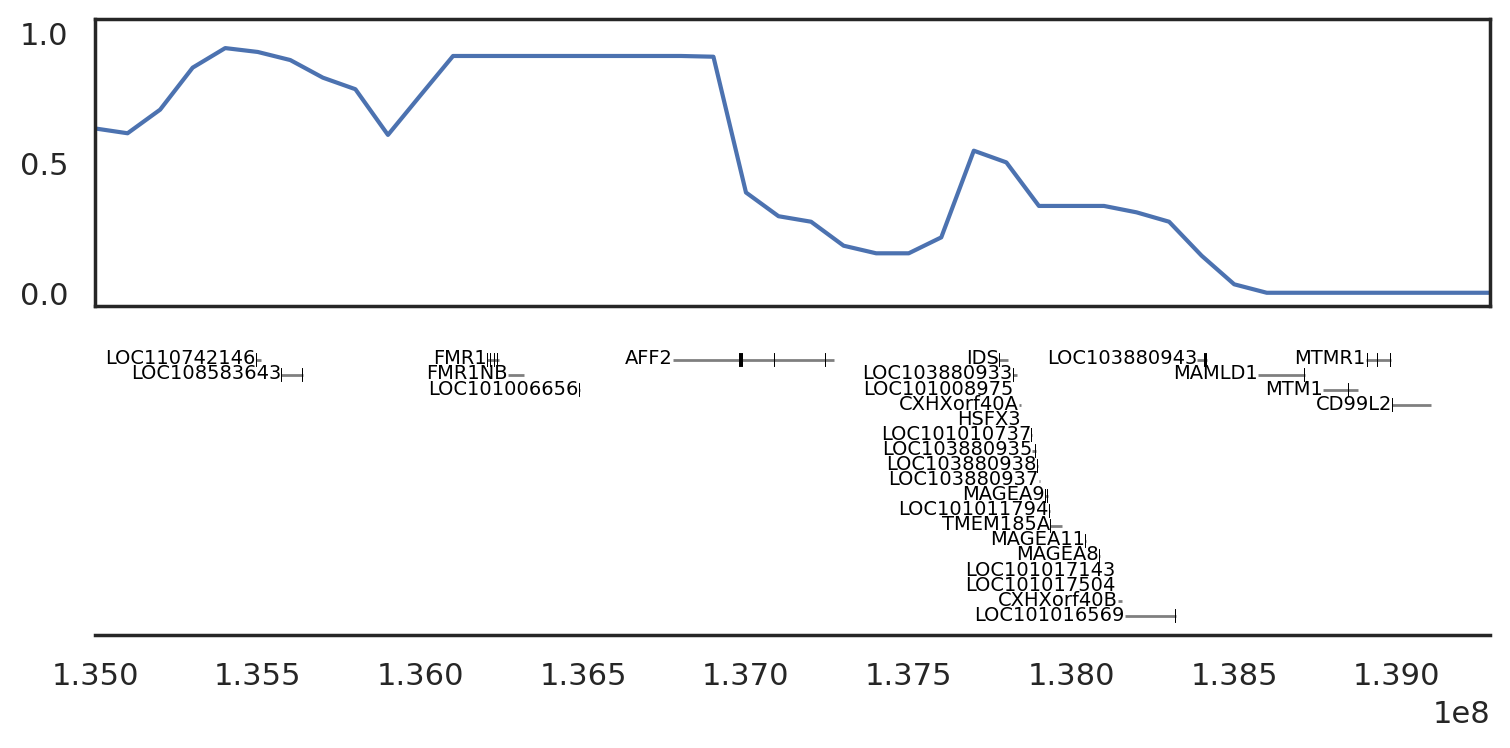

In [48]:
ax = gi.gene_plot('chrX', 135000000, 139000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
ax.plot(eth_chrX_adjusted.start, eth_chrX_adjusted["north_sum"])

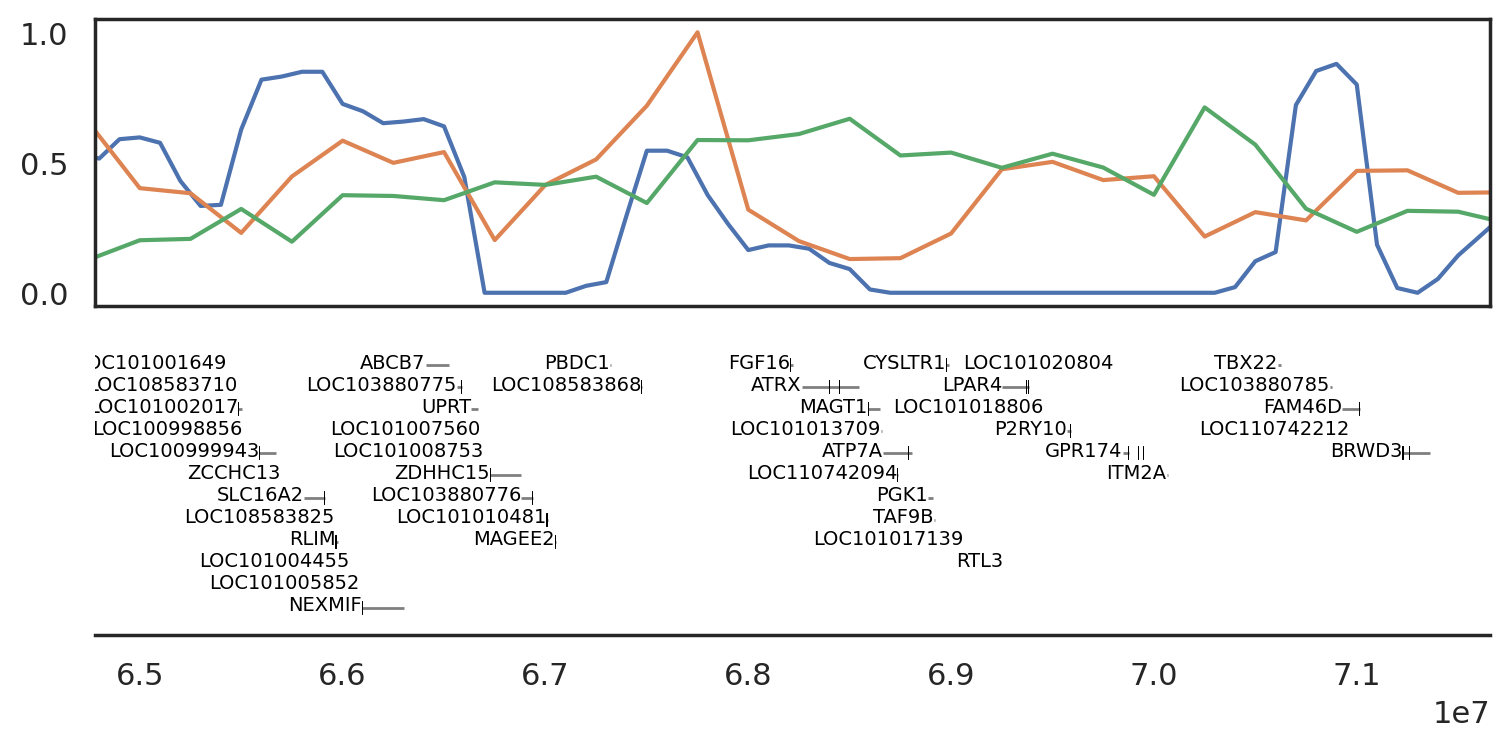

In [65]:
ax = gi.gene_plot('chrX', 65250000, 71250000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
ax.plot(eth_chrX_adjusted.start, eth_chrX_adjusted["north_sum"])
ax.plot(gog_df.start, (gog_df["norm_pi"])/(gog_df.norm_pi.max()))
ax.plot(fst_df_gf.start, fst_df_gf.fst)
